In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore", message="An unsupported index was provided. As a result, forecasts cannot be generated.")

### Reading In The Data

I've made the decision to remove the Covid datapoints from the unemployment and GDP dataset (Feb 2020 until March 2022). My logic is that covid was an anomalous event that doesn't represent the trends of the business cycle. It could have, however, effected the unemployment & GDP after the shock happened but that is hopefully covered by the two years worth of datapoints afterwards (2022-2024).

In [3]:
# Two datasets: unrate - Includes COVID, unrate_removed - Does not Include COVID
unrate = pd.read_csv('UNRATE.csv')
unrate['DATE'] = pd.to_datetime(unrate['DATE'])

# Making unrate_removed
start_date = '2020-02-01'
end_date = '2022-03-01'

pre_gap_data = unrate[unrate['DATE'] < start_date]
post_gap_data = unrate[unrate['DATE'] > end_date]

missing_period = pd.concat([pre_gap_data.tail(n=12)['UNRATE'], post_gap_data.head(n=13)['UNRATE']], ignore_index=True)
mean_post_gap = missing_period.mean()
variance_post_gap = missing_period.var()

missing_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
missing_values = np.random.normal(loc=mean_post_gap, scale=np.sqrt(variance_post_gap), size=len(missing_dates))

missing_data = pd.DataFrame({'DATE': missing_dates, 'UNRATE': missing_values})
unrate_removed = pd.concat([pre_gap_data, missing_data, post_gap_data], ignore_index=True)
unrate_removed = unrate_removed.sort_values(by='DATE').reset_index(drop=True)

### Checking for Stationarity

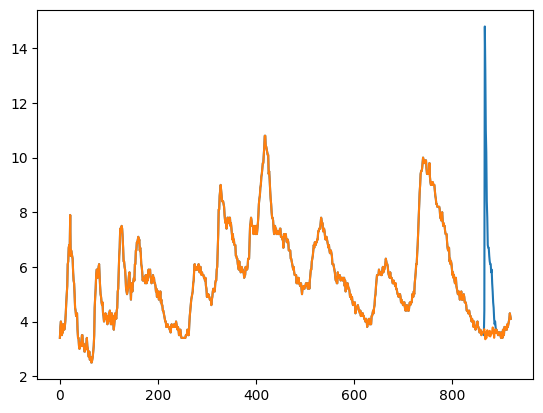

In [4]:
plt.plot(unrate['UNRATE'])
plt.plot(unrate_removed['UNRATE'])

To test for mean and variance stationarity we can run an ADF Test:

In [5]:
# Check the Augmented Dickey Fuller Test for mean stationarity
result = adfuller(unrate['UNRATE'], autolag='AIC', regression='c')
print(f'P value: {result[1]:.3f}')

result = adfuller(unrate_removed['UNRATE'], autolag='AIC', regression='c')
print(f'P value: {result[1]:.3f}')

print(f"""The Null Hypothesis: The time series has a unit root (the series is non-stationary).
We can reject the null hypothesis since the p-value is {result[1]:.3f}.
These results mean that the series is both mean and variance stationary.""")

P value: 0.002
P value: 0.037
The Null Hypothesis: The time series has a unit root (the series is non-stationary).
We can reject the null hypothesis since the p-value is 0.037.
These results mean that the series is both mean and variance stationary.


### Model Type Selection:

Since we already showed stationarity, the ARIMA model isn't needed here. We will focus on picking between a pure AR model, a pure MA model and a ARMA model. This will be done by looking at the ACF and PACF

NameError: name 'unrate1' is not defined

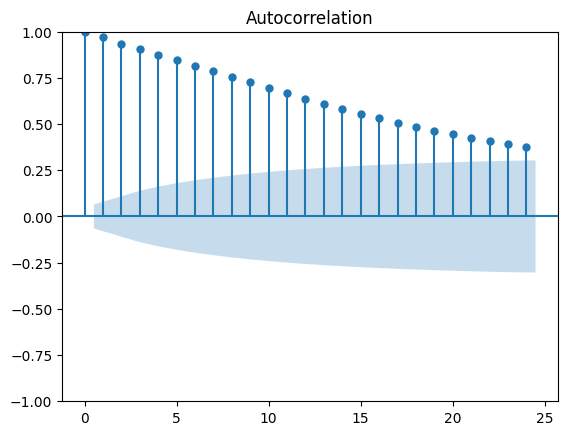

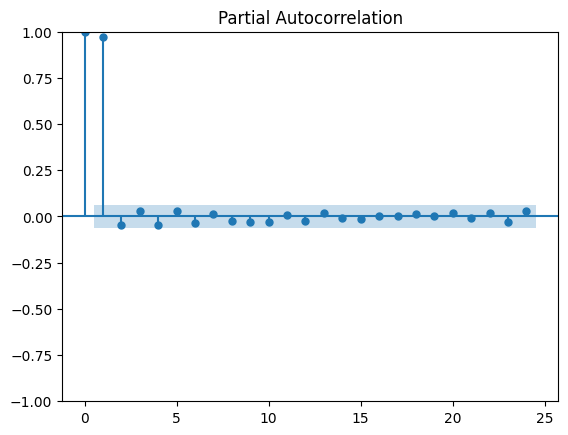

In [ ]:
# Check Autocorrelation plots (ACF)
plot_acf(unrate['UNRATE'], lags=24);
plot_pacf(unrate['UNRATE'], lags=24);
plot_acf(unrate_removed['UNRATE'], lags=24);
plot_pacf(unrate_removed['UNRATE'], lags=24);

Given the structure of the ACF, an AR model seems appropriate (Explain why and tell why the ARMA and MA dont work here) and even though there seems to be a persistence in the autocorrelations the PACF tells us that only up to the second lag matters so an AR(2) may be the best, lets test it using AIC:

### AR Model

In [ ]:
def do_aic(data=unrate['UNRATE'], l=2):
    model = AutoReg(data, lags=l)
    model_fitted = model.fit()
    aic = model_fitted.aic
    return aic

# With Covid Data
lst = []
for lag in range(1, 13):
    lst.append(do_aic(l=lag))

min_index = lst.index(np.min(lst)) + 1
print(f"(Covid) The Model with the minimum AIC SSR is an AR({min_index}) model: {np.min(lst):.3f}")

# Without Covid Data
lst = []
for lag in range(1, 13):
    lst.append(do_aic(data=unrate_removed['UNRATE'], l=lag))

min_index = lst.index(np.min(lst)) + 1
print(f"(No Covid) The Model with the minimum AIC SSR is an AR({min_index}) model: {np.min(lst):.3f}")


(Covid) The Model with the minimum AIC SSR is an AR(2) model: 994.811
(No Covid) The Model with the minimum AIC SSR is an AR(6) model: -443.191


(Without the Covid Data) Looking at the results of the AIC SSR, an AR(6) seems like the best model.

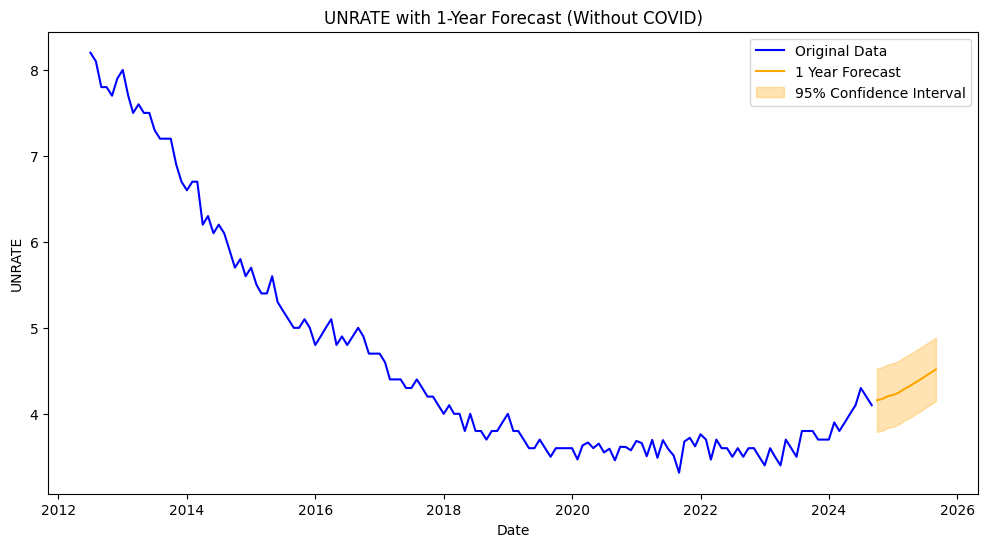

In [ ]:
# Fitting Model
model = AutoReg(unrate_removed['UNRATE'], lags=6)
fitted = model.fit()

# Getting Model Residuals
residuals = fitted.resid
noise_std_dev = residuals.std()

# Getting Noise Term
#noise_std_dev = unrate1['UNRATE'].iloc[-24:].var()

# 1 Year Forecast Predictions
forecast = fitted.predict(start=len(unrate_removed), end=len(unrate_removed) + 11)

# Calculate the standard error of the forecast (for each point)
forecast_se = np.full_like(forecast, noise_std_dev)

# Calculate 95% confidence intervals (Z-value for 95% CI = 1.96)
ci_upper = forecast + 1.96 * forecast_se
ci_lower = forecast - 1.96 * forecast_se

# Adding noise to forecast
# epsilon = np.random.normal(0, noise_std_dev, size=len(forecast))
# forecast = np.round(forecast + epsilon, 2)

# Creating dates for 1 year ahead forecasting
last_date = unrate_removed['DATE'].max()
extra_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
extra_data_removed = pd.DataFrame({'DATE': extra_dates, 'UNRATE': forecast, 'CI_lower': ci_lower, 'CI_upper': ci_upper})

# Plotting original data
plt.figure(figsize=(12, 6))
plt.plot(unrate_removed['DATE'][-147:], unrate_removed['UNRATE'][-147:], label='Original Data', color='blue')

# Plotting forecasted data
plt.plot(extra_data_removed['DATE'], extra_data_removed['UNRATE'], label='1 Year Forecast', color='orange')

# Plotting the 95% confidence interval as a shaded region (fan chart)
plt.fill_between(extra_data_removed['DATE'], extra_data_removed['CI_lower'], extra_data_removed['CI_upper'], color='orange', alpha=0.3, label='95% Confidence Interval')


# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('UNRATE')
plt.title('UNRATE with 1-Year Forecast (Without COVID)')
plt.legend()
plt.show()

(With the Covid Data) Looking at the results of the AIC SSR, an AR(2) seems like the best model.

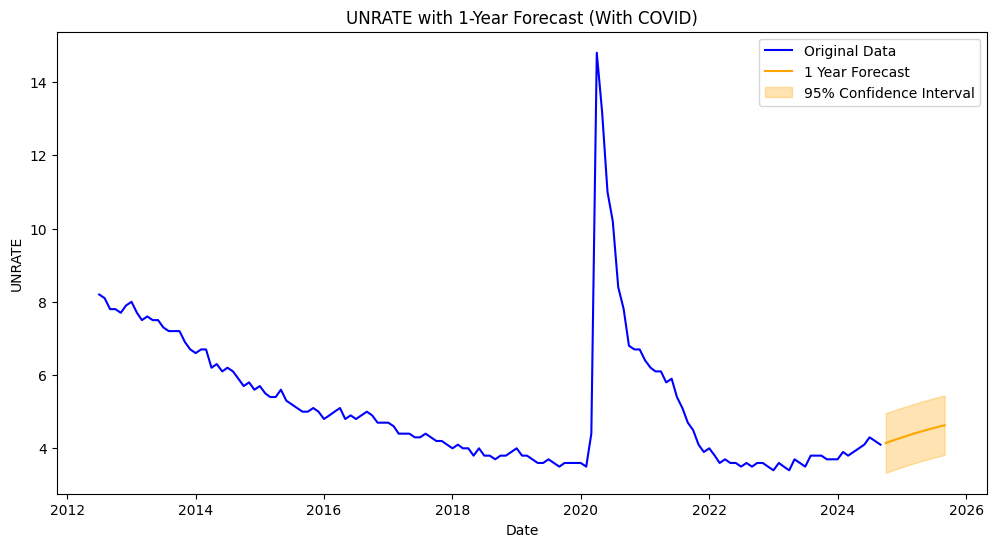

In [ ]:
# Fitting Model
model = AutoReg(unrate['UNRATE'], lags=2)
fitted = model.fit()

# Getting Model Residuals
residuals = fitted.resid
noise_std_dev = residuals.std()

# Getting Noise Term
#noise_std_dev = unrate['UNRATE'].iloc[-24:].var()

# 1 Year Forecast Predictions
forecast = fitted.predict(start=len(unrate), end=len(unrate) + 11)

# Calculate the standard error of the forecast (for each point)
forecast_se = np.full_like(forecast, noise_std_dev)

# Calculate 95% confidence intervals (Z-value for 95% CI = 1.96)
ci_upper = forecast + 1.96 * forecast_se
ci_lower = forecast - 1.96 * forecast_se

# Adding noise to forecast
# epsilon = np.random.normal(0, noise_std_dev, size=len(forecast))
# forecast = np.round(forecast + epsilon, 2)

# Creating dates for 1 year ahead forecasting
last_date = unrate['DATE'].max()
extra_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
extra_data = pd.DataFrame({'DATE': extra_dates, 'UNRATE': forecast, 'CI_lower': ci_lower, 'CI_upper': ci_upper})

# Plotting original data
plt.figure(figsize=(12, 6))
plt.plot(unrate['DATE'][-147:], unrate['UNRATE'][-147:], label='Original Data', color='blue')

# Plotting forecasted data
plt.plot(extra_data['DATE'], extra_data['UNRATE'], label='1 Year Forecast', color='orange')

# Plotting the 95% confidence interval as a shaded region (fan chart)
plt.fill_between(extra_data['DATE'], extra_data['CI_lower'], extra_data['CI_upper'], color='orange', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('UNRATE')
plt.title('UNRATE with 1-Year Forecast (With COVID)')
plt.legend()
plt.show()


In [ ]:
print(extra_data-extra_data_removed)

      DATE    UNRATE  CI_lower  CI_upper
921 0 days -0.012172 -0.454711  0.430367
922 0 days  0.023031 -0.419508  0.465570
923 0 days  0.042385 -0.400154  0.484924
924 0 days  0.076963 -0.365576  0.519502
925 0 days  0.097378 -0.345161  0.539917
926 0 days  0.104616 -0.337923  0.547155
927 0 days  0.114169 -0.328370  0.556708
928 0 days  0.118257 -0.324282  0.560796
929 0 days  0.121032 -0.321507  0.563571
930 0 days  0.120183 -0.322356  0.562722
931 0 days  0.117105 -0.325434  0.559644
932 0 days  0.112934 -0.329605  0.555473
